In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
setup_google_colab.setup_week5()

TensorFlow 1.x selected.
shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-10-29 08:00:55--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-10-29 08:00:55 (49.7 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



# Generating names with recurrent neural networks

This time we'll find ourselves delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how we'll come up with a name for kids. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

Instructions for updating:
non-resource variables are not supported in the long term
1.15.2


Using TensorFlow backend.


# Load data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow us to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [3]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [4]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


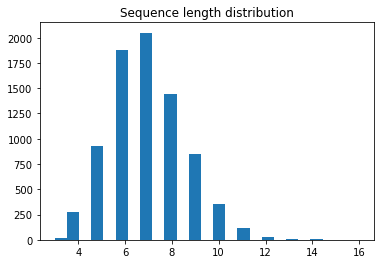

In [5]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [6]:
#tokens: all unique characters go here, padding included!
tokens = set()
for name in names:
    for char in name:
        tokens.add(char)
tokens = list(tokens)
print(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

['v', 'Z', 'H', 'N', 'g', 'o', 'Y', 'e', 'p', 'd', 'Q', '-', 'b', 'h', 'A', ' ', 'i', 'y', 'L', 'k', 'E', 'r', 's', 'X', 'a', 'l', 'm', "'", 'M', 'F', 'R', 'q', 'B', 'n', 'x', 'j', 'w', 'I', 'U', 'c', 'G', 'C', 'J', 'O', 'P', 'S', 'T', 'W', 'u', 'D', 'f', 'K', 't', 'V', 'z']
n_tokens: 55


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign `token_to_id`

In [7]:
#token_to_id = ### create a dictionary of {symbol -> its  index in tokens}
#token_to_id = dict()
#token_to_id = dict(enumerate(tokens))
#print(token_to_id)

#for k, v in enumerate(tokens):
#token_to_id[v] = k
#token_to_id = {k:v for v,k in enumerate(tokens)}

token_to_id = {}
token_to_id = {v:k for k,v in enumerate(tokens)}
print(token_to_id)

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

{'v': 0, 'Z': 1, 'H': 2, 'N': 3, 'g': 4, 'o': 5, 'Y': 6, 'e': 7, 'p': 8, 'd': 9, 'Q': 10, '-': 11, 'b': 12, 'h': 13, 'A': 14, ' ': 15, 'i': 16, 'y': 17, 'L': 18, 'k': 19, 'E': 20, 'r': 21, 's': 22, 'X': 23, 'a': 24, 'l': 25, 'm': 26, "'": 27, 'M': 28, 'F': 29, 'R': 30, 'q': 31, 'B': 32, 'n': 33, 'x': 34, 'j': 35, 'w': 36, 'I': 37, 'U': 38, 'c': 39, 'G': 40, 'C': 41, 'J': 42, 'O': 43, 'P': 44, 'S': 45, 'T': 46, 'W': 47, 'u': 48, 'D': 49, 'f': 50, 'K': 51, 't': 52, 'V': 53, 'z': 54}
Seems alright!


In [8]:
#def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [9]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[15 14 12 24  4 24  7 25  0]
 [15 40 25  5 21 17  0  0  0]
 [15 44 21 16 22 22 16  7  0]
 [15 40 16  5  0 24 33 33  7]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week5/rnn.png?raw=1" width=600>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

In [10]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()

In [11]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
#get_h_next = ### YOUR CODE HERE
get_h_next = Dense(rnn_num_units, activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
#get_probas = ### YOUR CODE HERE 
get_probas = Dense(n_tokens, activation='softmax')

We will generate names character by character starting with `start_token`:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week5/char-nn.png?raw=1" width=600>

In [12]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    #x_and_h = ### YOUR CODE HERE
    x_and_h = tf.concat([x_t_emb,h_t],1)
    
    # compute next state given x_and_h
    #h_next = ### YOUR CODE HERE
    h_next = get_h_next(x_and_h) 
    
    # get probabilities for language model P(x_next|h_next)
    #output_probas = ### YOUR CODE HERE
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

# RNN: loop

Once `rnn_one_step` is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [13]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

# RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

We will flatten our matrices to shape [None, n_tokens] to make it easier.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [14]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

Usually it's a good idea to ignore gradients of loss for padding token predictions.

Because we don't care about further prediction after the pad_token is predicted for the first time, so it doesn't make sense to punish our network after the pad_token is predicted.

For simplicity you can ignore this comment, it's up to you.

In [15]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
#loss = ### YOUR CODE HERE
loss = tf.reduce_mean(-answers_matrix*tf.log(predictions_matrix))

optimize = tf.train.AdamOptimizer().minimize(loss)

# RNN: training

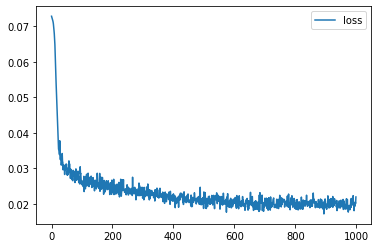

In [16]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [17]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [18]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [19]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Pelinhvvvvvvvvv
 Momrarycevvvvvv
 Winptovvvvvvvvv
 Ronhavvvvvvvvvv
 Ehonvvvvvvvvvvv
 Cjalavvvvvvvvvv
 Cirgvvvvvvvvvvv
 Ceniavvvvvvvvvv
 Wennvvvvvvvvvvv
 Tievvvvvvvvvvvv


In [20]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

 Trumpyvvvvvvvvv
 Trumpyvvvvvvvvv
 Trumpavrvvvvvvv
 Trumphovvvvvvvv
 Trumpavvvvvvvvv
 Trumpavvvvvvvvv
 Trumpvvvvvvvvvv
 Trumprevvvvvvvv
 Trumpocavvvvvvv
 Trumpuvvvvvvvvv
